/opt/anaconda3/envs/nfl_data_py/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 80s 365ms/step - accuracy: 0.4572 - loss: 0.9102 - val_accuracy: 0.4139 - val_loss: 1.0575
Epoch 2/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 74s 347ms/step - accuracy: 0.5467 - loss: 0.8349 - val_accuracy: 0.4837 - val_loss: 0.9473
Epoch 3/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 84s 398ms/step - accuracy: 0.5988 - loss: 0.7451 - val_accuracy: 0.4938 - val_loss: 0.9338
Epoch 4/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 74s 348ms/step - accuracy: 0.6394 - loss: 0.6772 - val_accuracy: 0.5577 - val_loss: 0.8256
Epoch 5/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 80s 377ms/step - accuracy: 0.6509 - loss: 0.6536 - val_accuracy: 0.6110 - val_loss: 0.7262
Epoch 6/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 80s 375ms/step - accuracy: 0.6584 - loss: 0.6529 - val_accuracy: 0.6400 - val_loss: 0.6886
Epoch 7/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 78s 368ms/step - accuracy: 0.6913 - loss: 0.5951 - val_accuracy: 0.6536 - val_loss: 0.6741
Epoch 8/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 78s 367ms/step - accuracy: 0.6961 - loss: 0

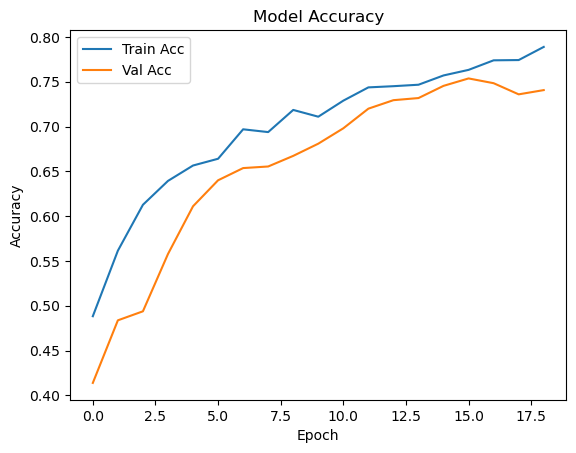

53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step

Classification Report:

              precision    recall  f1-score   support

   Authentic       0.94      0.77      0.85      1499
    Tampered       0.26      0.63      0.37       190

    accuracy                           0.75      1689
   macro avg       0.60      0.70      0.61      1689
weighted avg       0.87      0.75      0.79      1689



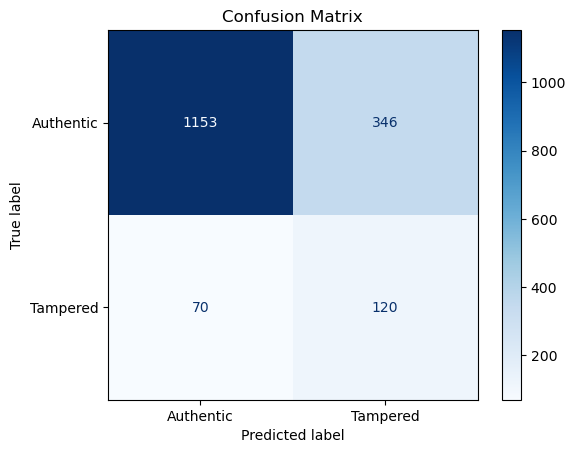

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --------------------------
# Load Metadata
# --------------------------
df = pd.read_csv('filtered_photos_metadata.csv')

# Encode labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['Label'])

# --------------------------
# Load and Preprocess Images
# --------------------------
IMG_SIZE = 224
X, y = [], []

IMAGE_DIR = "Filtered Formatted Photos"  # Confirm path if needed

for _, row in df.iterrows():
    file_path = os.path.join(IMAGE_DIR, os.path.basename(row['File Path']))
    img = cv2.imread(file_path)
    if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = preprocess_input(img)
        X.append(img)
        y.append(row['encoded_label'])

X = np.array(X)
y = np.array(y)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# One-hot encode labels
y_cat = to_categorical(y)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

# --------------------------
# Data Augmentation
# --------------------------
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

# --------------------------
# Build and Fine-tune Model
# --------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True  # unfreeze entire model

# Optional: freeze bottom layers, fine-tune only top layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# --------------------------
# Train Model
# --------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# --------------------------
# Plot Accuracy
# --------------------------
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# --------------------------
# Confusion Matrix & Report
# --------------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

/opt/anaconda3/envs/nfl_data_py/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 196s 508ms/step - accuracy: 0.5049 - auc: 0.5035 - loss: 0.0531 - precision: 0.5049 - recall: 0.5049 - val_accuracy: 0.5042 - val_auc: 0.5082 - val_loss: 0.0462 - val_precision: 0.5042 - val_recall: 0.5042 - learning_rate: 1.0000e-05
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 183s 488ms/step - accuracy: 0.5043 - auc: 0.5045 - loss: 0.0498 - precision: 0.5043 - recall: 0.5043 - val_accuracy: 0.5375 - val_auc: 0.5387 - val_loss: 0.0438 - val_precision: 0.5375 - val_recall: 0.5375 - learning_rate: 1.0000e-05
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 190s 506ms/step - accuracy: 0.5105 - auc: 0.5219 - loss: 0.0475 - precision: 0.5105 - recall: 0.5105 - val_accuracy: 0.5189 - val_auc: 0.5326 - val_loss: 0.0437 - val_precision: 0.5189 - val_recall: 0.5189 - learning_rate: 1.0000e-05
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 207s 550ms/step - accuracy: 0.5162 - auc: 0.5152 - loss: 0.0474 - precision: 0.5162 - recall: 0.5162 - val_accuracy: 0.5315 - val_auc: 0.5

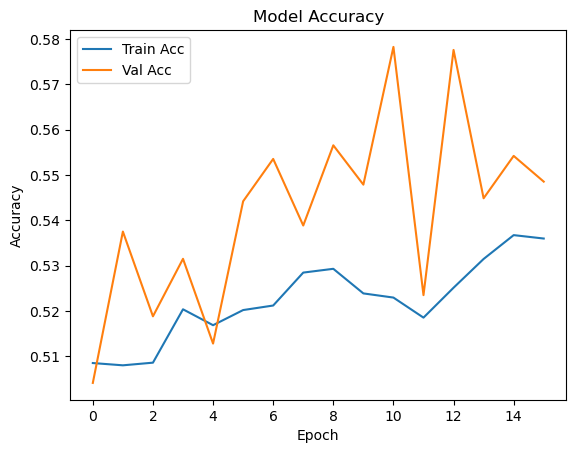

94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 329ms/step

Classification Report:

              precision    recall  f1-score   support

   Authentic       0.62      0.40      0.49      1499
    Tampered       0.56      0.75      0.64      1498

    accuracy                           0.58      2997
   macro avg       0.59      0.58      0.56      2997
weighted avg       0.59      0.58      0.56      2997



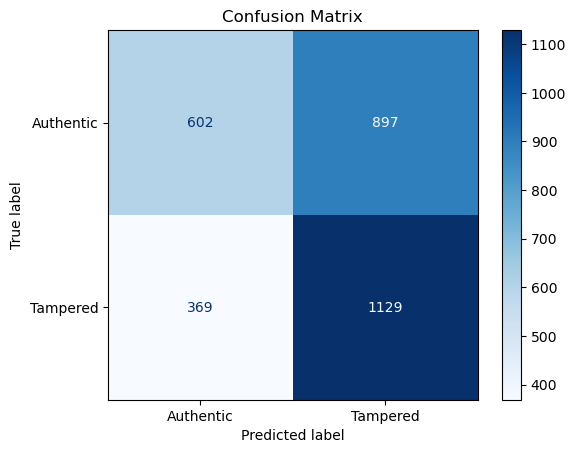

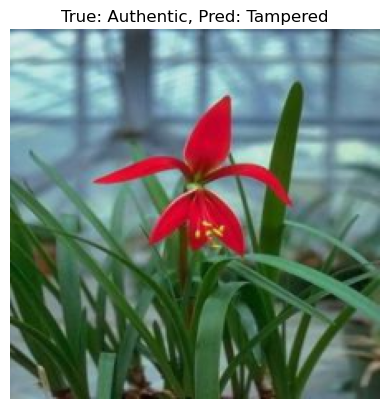

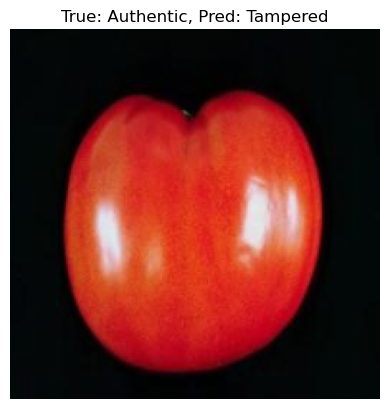

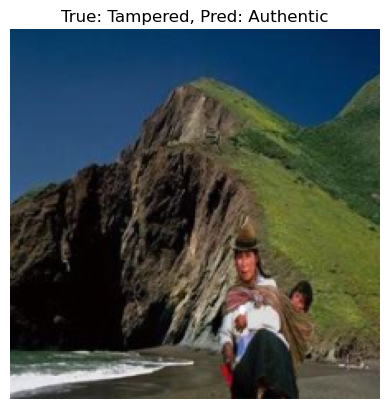

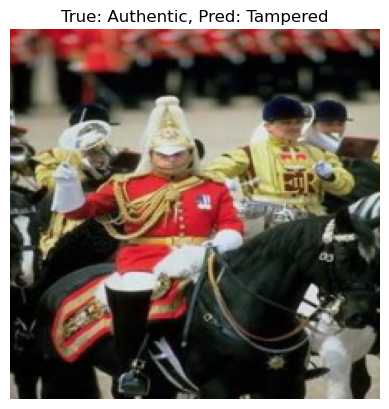

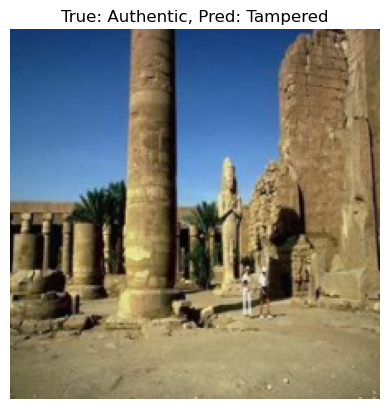

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K

# --------------------------
# Load Metadata
# --------------------------
df = pd.read_csv('filtered_photos_metadata.csv')
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['Label'])

# --------------------------
# Load and Preprocess Images
# --------------------------
IMG_SIZE = 224
X, y = [], []
IMAGE_DIR = "Filtered Formatted Photos"

for _, row in df.iterrows():
    file_path = os.path.join(IMAGE_DIR, os.path.basename(row['File Path']))
    img = cv2.imread(file_path)
    if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = preprocess_input(img)
        X.append(img)
        y.append(row['encoded_label'])

X = np.array(X)
y = np.array(y)

# --------------------------
# Oversample Minority Class
# --------------------------
X_flat = X.reshape((X.shape[0], -1))
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_flat, y)
X_resampled = X_resampled.reshape((-1, IMG_SIZE, IMG_SIZE, 3))
y_cat_resampled = to_categorical(y_resampled)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_cat_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --------------------------
# Data Augmentation
# --------------------------
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

# --------------------------
# Focal Loss Function
# --------------------------
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# --------------------------
# Build and Compile Model
# --------------------------
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# --------------------------
# Callbacks
# --------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1)

# --------------------------
# Train Model
# --------------------------
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[early_stop, lr_schedule]
)

# --------------------------
# Plot Accuracy
# --------------------------
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# --------------------------
# Confusion Matrix & Report
# --------------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# Visualize Misclassified Images
# --------------------------
misclassified_indices = np.where(y_pred != y_true)[0]
for i in misclassified_indices[:5]:  # show first 5
    plt.imshow((X_test[i] + 1) / 2)  # convert back from preprocess_input
    plt.title(f"True: {label_encoder.classes_[y_true[i]]}, Pred: {label_encoder.classes_[y_pred[i]]}")
    plt.axis('off')
    plt.show()


/opt/anaconda3/envs/nfl_data_py/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 158s 540ms/step - accuracy: 0.5333 - auc_2: 0.5419 - loss: 0.7248 - precision_2: 0.5333 - recall_2: 0.5333 - val_accuracy: 0.6161 - val_auc_2: 0.6554 - val_loss: 0.6577 - val_precision_2: 0.6161 - val_recall_2: 0.6161 - learning_rate: 1.0000e-05
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 155s 552ms/step - accuracy: 0.5816 - auc_2: 0.6137 - loss: 0.6750 - precision_2: 0.5816 - recall_2: 0.5816 - val_accuracy: 0.6690 - val_auc_2: 0.7230 - val_loss: 0.6183 - val_precision_2: 0.6690 - val_recall_2: 0.6690 - learning_rate: 1.0000e-05
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 166s 591ms/step - accuracy: 0.6278 - auc_2: 0.6790 - loss: 0.6319 - precision_2: 0.6278 - recall_2: 0.6278 - val_accuracy: 0.7046 - val_auc_2: 0.7646 - val_loss: 0.5875 - val_precision_2: 0.7046 - val_recall_2: 0.7046 - learning_rate: 1.0000e-05
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 166s 591ms/step - accuracy: 0.6542 - auc_2: 0.7162 - loss: 0.6041 - precision_2: 0.6542 - recall_2: 0.

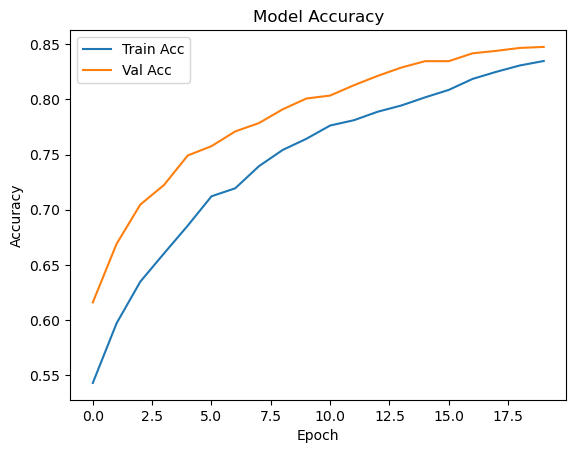

71/71 ━━━━━━━━━━━━━━━━━━━━ 27s 372ms/step

Classification Report:

              precision    recall  f1-score   support

   Authentic       0.92      0.85      0.88      1499
    Tampered       0.74      0.84      0.79       749

    accuracy                           0.85      2248
   macro avg       0.83      0.85      0.83      2248
weighted avg       0.86      0.85      0.85      2248



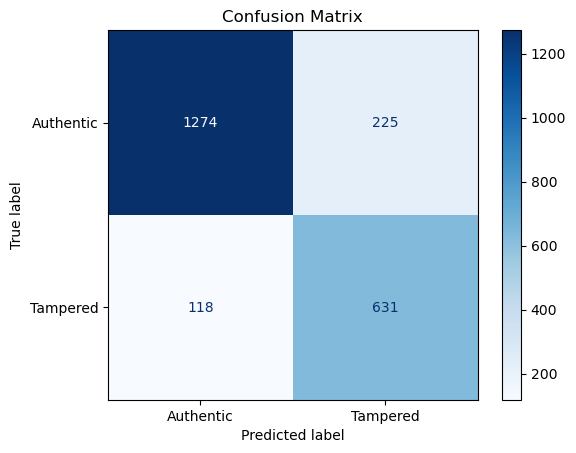

In [3]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC

# --------------------------
# Load and Balance Metadata
# --------------------------
df = pd.read_csv('filtered_photos_metadata.csv')
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['Label'])

# Controlled oversampling: Upsample Tampered to 50% of Authentic
df_authentic = df[df['Label'] == 'Authentic']
df_tampered = df[df['Label'] == 'Tampered']
df_tampered_upsampled = df_tampered.sample(n=int(len(df_authentic) * 0.5), replace=True, random_state=42)

df_balanced = pd.concat([df_authentic, df_tampered_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# --------------------------
# Load and Preprocess Images
# --------------------------
IMG_SIZE = 224
X, y = [], []
IMAGE_DIR = "Filtered Formatted Photos"

for _, row in df_balanced.iterrows():
    file_path = os.path.join(IMAGE_DIR, os.path.basename(row['File Path']))
    img = cv2.imread(file_path)
    if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = preprocess_input(img)
        X.append(img)
        y.append(row['encoded_label'])

X = np.array(X)
y = np.array(y)
y_cat = to_categorical(y)

# Class weights to balance minor class loss signal
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --------------------------
# Train/Test Split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y, random_state=42
)

# --------------------------
# Data Augmentation
# --------------------------
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

# --------------------------
# Model: EfficientNetB0
# --------------------------
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# --------------------------
# Callbacks
# --------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1)

# --------------------------
# Train
# --------------------------
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[early_stop, lr_schedule],
    class_weight=class_weight_dict
)

# --------------------------
# Plot Accuracy
# --------------------------
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# --------------------------
# Confusion Matrix & Report
# --------------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()